In [1]:
# Experiment 1 of End-to-end training with the baseline model model 1.
# Try to find the time and accuracy of the models for different sizes of the dataset under same number of training iterations.
# Based on the code of Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The credit of this code goes to Guillaume Chevalier under MIT License.
# Python version 3.6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"

# Functions to load the input data
def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array so when we test the model with different datasize, 
# we can have a roughly evenly distributed classes of data
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

# Define LSTM and other helper functions.
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
runing_time_list = []
accuracy_list = []
loss_list = []

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]

    print(np.array(X_train).shape)

    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32 # Hidden layer num of features
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 300  # Loop 300 times on the dataset
    batch_size = 1500
    display_iter = 30000  # To show test set accuracy during training

    # Training the neural net

    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    # Graph weights
    weights = {
        'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([n_hidden])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    pred = LSTM_RNN(x, weights, biases)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            loss, acc = sess.run(
                [cost, accuracy], 
                feed_dict={
                    x: X_test,
                    y: one_hot(y_test)
                }
            )
            test_losses.append(loss)
            test_accuracies.append(acc)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss) + \
                  ", Accuracy = {}".format(acc))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")
    runing_time_list.append(time.time() - start_time)

    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    test_losses.append(final_loss)
    test_accuracies.append(accuracy)

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))
    accuracy_list.append(accuracy)
    loss_list.append(final_loss)

print("------------------------")
print("FINAL RESULTS LIST:")
print(runing_time_list)
print(accuracy_list)
print(loss_list)

read in the data
(7352, 1)
(735, 128, 9)
Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

start training
Training iter #1500:   Batch Loss = 3.278865, Accuracy = 0.21266666054725647
PERFORMANCE ON TEST SET: Batch Loss = 2.7628653049468994, Accuracy = 0.17102137207984924
Training iter #30000:   Batch Loss = 1.282398, Accuracy = 0.7946666479110718
PERFORMANCE ON TEST SET: Batch Loss = 1.6525483131408691, Accuracy = 0.6338649392127991
Training iter #60000:   Batch Loss = 0.768922, Accuracy = 0.968666672706604
PERFORMANCE ON TEST SET: Batch Loss = 2.136003017425537, Accuracy = 0.6674584150314331
Training iter #90000:   Batch Loss = 0.734059, Accuracy = 0.9693333506584167
PERFORMANCE ON TEST SET: Batch Loss = 2.32218074798584, Accuracy = 0.6796742677688599
Training iter #120000:   

PERFORMANCE ON TEST SET: Batch Loss = 1.043666124343872, Accuracy = 0.8625721335411072
Training iter #630000:   Batch Loss = 0.485018, Accuracy = 0.9620000123977661
PERFORMANCE ON TEST SET: Batch Loss = 0.9554168581962585, Accuracy = 0.8676620125770569
Training iter #660000:   Batch Loss = 0.440648, Accuracy = 0.9866666793823242
PERFORMANCE ON TEST SET: Batch Loss = 0.9751615524291992, Accuracy = 0.8724126219749451
Optimization Finished!
Training time is: 539.417266368866 seconds
FINAL RESULT: Batch Loss = 0.9736613631248474, Accuracy = 0.873430609703064
(7352, 1)
(2941, 128, 9)
start training
Training iter #1500:   Batch Loss = 2.642318, Accuracy = 0.19333332777023315
PERFORMANCE ON TEST SET: Batch Loss = 2.3602850437164307, Accuracy = 0.2422802895307541
Training iter #30000:   Batch Loss = 1.216116, Accuracy = 0.7586666941642761
PERFORMANCE ON TEST SET: Batch Loss = 1.6336779594421387, Accuracy = 0.6352222561836243
Training iter #60000:   Batch Loss = 0.934565, Accuracy = 0.892000019

Training iter #450000:   Batch Loss = 0.527809, Accuracy = 0.9633333086967468
PERFORMANCE ON TEST SET: Batch Loss = 1.1117403507232666, Accuracy = 0.8601968288421631
Training iter #480000:   Batch Loss = 0.538709, Accuracy = 0.9380000233650208
PERFORMANCE ON TEST SET: Batch Loss = 1.1557722091674805, Accuracy = 0.8595181703567505
Training iter #510000:   Batch Loss = 0.530490, Accuracy = 0.9473333358764648
PERFORMANCE ON TEST SET: Batch Loss = 1.088542103767395, Accuracy = 0.8571428656578064
Training iter #540000:   Batch Loss = 0.516378, Accuracy = 0.9539999961853027
PERFORMANCE ON TEST SET: Batch Loss = 1.072484016418457, Accuracy = 0.8574821949005127
Training iter #570000:   Batch Loss = 0.484049, Accuracy = 0.9626666903495789
PERFORMANCE ON TEST SET: Batch Loss = 1.1348122358322144, Accuracy = 0.8547675609588623
Training iter #600000:   Batch Loss = 0.496381, Accuracy = 0.9473333358764648
PERFORMANCE ON TEST SET: Batch Loss = 1.1630327701568604, Accuracy = 0.8520529270172119
Traini

PERFORMANCE ON TEST SET: Batch Loss = 0.8553009033203125, Accuracy = 0.8775025606155396
Training iter #810000:   Batch Loss = 0.476468, Accuracy = 0.949999988079071
PERFORMANCE ON TEST SET: Batch Loss = 0.8600220680236816, Accuracy = 0.8717339634895325
Training iter #840000:   Batch Loss = 0.461365, Accuracy = 0.9539999961853027
PERFORMANCE ON TEST SET: Batch Loss = 0.8308981657028198, Accuracy = 0.88802170753479
Training iter #870000:   Batch Loss = 0.417453, Accuracy = 0.9726666808128357
PERFORMANCE ON TEST SET: Batch Loss = 0.8344125747680664, Accuracy = 0.8808958530426025
Training iter #900000:   Batch Loss = 0.406693, Accuracy = 0.981333315372467
PERFORMANCE ON TEST SET: Batch Loss = 0.8574891090393066, Accuracy = 0.8778418898582458
Training iter #930000:   Batch Loss = 0.560783, Accuracy = 0.890666663646698
PERFORMANCE ON TEST SET: Batch Loss = 1.0396809577941895, Accuracy = 0.8011537194252014
Training iter #960000:   Batch Loss = 0.432650, Accuracy = 0.9726666808128357
PERFORMAN

Training iter #900000:   Batch Loss = 0.376699, Accuracy = 0.9760000109672546
PERFORMANCE ON TEST SET: Batch Loss = 0.7825782299041748, Accuracy = 0.8927723169326782
Training iter #930000:   Batch Loss = 0.414649, Accuracy = 0.9419999718666077
PERFORMANCE ON TEST SET: Batch Loss = 0.7908875942230225, Accuracy = 0.8887003660202026
Training iter #960000:   Batch Loss = 0.361012, Accuracy = 0.9806666374206543
PERFORMANCE ON TEST SET: Batch Loss = 0.7476741075515747, Accuracy = 0.8934509754180908
Training iter #990000:   Batch Loss = 0.368358, Accuracy = 0.9753333330154419
PERFORMANCE ON TEST SET: Batch Loss = 0.7894287109375, Accuracy = 0.8866643905639648
Training iter #1020000:   Batch Loss = 0.383858, Accuracy = 0.95333331823349
PERFORMANCE ON TEST SET: Batch Loss = 0.8137689828872681, Accuracy = 0.8778418898582458
Training iter #1050000:   Batch Loss = 0.366832, Accuracy = 0.9713333249092102
PERFORMANCE ON TEST SET: Batch Loss = 0.8245559930801392, Accuracy = 0.8737699389457703
Trainin

PERFORMANCE ON TEST SET: Batch Loss = 0.9550886750221252, Accuracy = 0.8985409140586853
Training iter #810000:   Batch Loss = 0.559837, Accuracy = 0.9326666593551636
PERFORMANCE ON TEST SET: Batch Loss = 0.8896909952163696, Accuracy = 0.8944689631462097
Training iter #840000:   Batch Loss = 0.443038, Accuracy = 0.9693333506584167
PERFORMANCE ON TEST SET: Batch Loss = 0.873776912689209, Accuracy = 0.8988802433013916
Training iter #870000:   Batch Loss = 0.428528, Accuracy = 0.9879999756813049
PERFORMANCE ON TEST SET: Batch Loss = 0.8090881109237671, Accuracy = 0.9026128053665161
Training iter #900000:   Batch Loss = 0.409683, Accuracy = 0.987333357334137
PERFORMANCE ON TEST SET: Batch Loss = 0.8416591882705688, Accuracy = 0.8995589017868042
Training iter #930000:   Batch Loss = 0.386477, Accuracy = 0.9980000257492065
PERFORMANCE ON TEST SET: Batch Loss = 0.8585647344589233, Accuracy = 0.9015948176383972
Training iter #960000:   Batch Loss = 0.451091, Accuracy = 0.9660000205039978
PERFOR

Training iter #480000:   Batch Loss = 0.712615, Accuracy = 0.8799999952316284
PERFORMANCE ON TEST SET: Batch Loss = 1.0060139894485474, Accuracy = 0.8785205483436584
Training iter #510000:   Batch Loss = 0.580648, Accuracy = 0.9726666808128357
PERFORMANCE ON TEST SET: Batch Loss = 0.9565333127975464, Accuracy = 0.8958262801170349
Training iter #540000:   Batch Loss = 0.606179, Accuracy = 0.9319999814033508
PERFORMANCE ON TEST SET: Batch Loss = 0.9645205140113831, Accuracy = 0.8903970122337341
Training iter #570000:   Batch Loss = 0.576234, Accuracy = 0.9433333277702332
PERFORMANCE ON TEST SET: Batch Loss = 0.966318666934967, Accuracy = 0.8866643905639648
Training iter #600000:   Batch Loss = 0.581735, Accuracy = 0.9333333373069763
PERFORMANCE ON TEST SET: Batch Loss = 1.0088659524917603, Accuracy = 0.8849677443504333
Training iter #630000:   Batch Loss = 0.563320, Accuracy = 0.9506666660308838
PERFORMANCE ON TEST SET: Batch Loss = 1.1261179447174072, Accuracy = 0.8527315855026245
Train

PERFORMANCE ON TEST SET: Batch Loss = 0.6977745294570923, Accuracy = 0.8669833540916443
Training iter #1980000:   Batch Loss = 0.321337, Accuracy = 0.9506666660308838
PERFORMANCE ON TEST SET: Batch Loss = 0.8137949705123901, Accuracy = 0.8527315855026245
Optimization Finished!
Training time is: 4653.333568572998 seconds
FINAL RESULT: Batch Loss = 0.746449887752533, Accuracy = 0.8693586587905884
(7352, 1)
(7352, 128, 9)
start training
Training iter #1500:   Batch Loss = 2.672680, Accuracy = 0.009333333000540733
PERFORMANCE ON TEST SET: Batch Loss = 2.3910863399505615, Accuracy = 0.39972853660583496
Training iter #30000:   Batch Loss = 1.320608, Accuracy = 0.6933333277702332
PERFORMANCE ON TEST SET: Batch Loss = 1.3748526573181152, Accuracy = 0.6674584150314331
Training iter #60000:   Batch Loss = 1.195260, Accuracy = 0.7540000081062317
PERFORMANCE ON TEST SET: Batch Loss = 1.3409698009490967, Accuracy = 0.7197149395942688
Training iter #90000:   Batch Loss = 1.017835, Accuracy = 0.85799

Training iter #1410000:   Batch Loss = 0.366369, Accuracy = 0.9626666903495789
PERFORMANCE ON TEST SET: Batch Loss = 0.7184369564056396, Accuracy = 0.8652867078781128
Training iter #1440000:   Batch Loss = 0.349151, Accuracy = 0.9713333249092102
PERFORMANCE ON TEST SET: Batch Loss = 0.628272294998169, Accuracy = 0.8924329876899719
Training iter #1470000:   Batch Loss = 0.410931, Accuracy = 0.9520000219345093
PERFORMANCE ON TEST SET: Batch Loss = 0.6402058601379395, Accuracy = 0.8836104273796082
Training iter #1500000:   Batch Loss = 0.393191, Accuracy = 0.9393333196640015
PERFORMANCE ON TEST SET: Batch Loss = 0.6870869994163513, Accuracy = 0.8805565237998962
Training iter #1530000:   Batch Loss = 0.314105, Accuracy = 0.9633333086967468
PERFORMANCE ON TEST SET: Batch Loss = 0.688265323638916, Accuracy = 0.8839497566223145
Training iter #1560000:   Batch Loss = 0.323550, Accuracy = 0.9626666903495789
PERFORMANCE ON TEST SET: Batch Loss = 0.7356846332550049, Accuracy = 0.8703766465187073


read in the data
(7352, 1)
(7352, 128, 9)
start training
Training iter #1500:   Batch Loss = 3.993079, Accuracy = 0.1653333306312561
PERFORMANCE ON TEST SET: Batch Loss = 3.1482207775115967, Accuracy = 0.18221920728683472
Training iter #300000:   Batch Loss = 0.673940, Accuracy = 0.9626666903495789
PERFORMANCE ON TEST SET: Batch Loss = 0.9710876941680908, Accuracy = 0.8724126219749451
Training iter #600000:   Batch Loss = 0.611907, Accuracy = 0.9233333468437195
PERFORMANCE ON TEST SET: Batch Loss = 0.989443302154541, Accuracy = 0.8693586587905884
Training iter #900000:   Batch Loss = 0.468934, Accuracy = 0.9666666388511658
PERFORMANCE ON TEST SET: Batch Loss = 0.786361575126648, Accuracy = 0.8849677443504333
Training iter #1200000:   Batch Loss = 0.439657, Accuracy = 0.9466666579246521
PERFORMANCE ON TEST SET: Batch Loss = 0.7811511754989624, Accuracy = 0.8863250613212585
Training iter #1500000:   Batch Loss = 0.405759, Accuracy = 0.9386666417121887
PERFORMANCE ON TEST SET: Batch Loss 

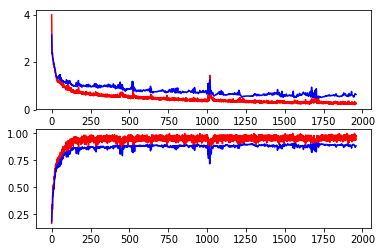

In [3]:
# Experiment 2 Part 1 of End-to-end training with the baseline model model 1.
# Finding the optimal number of iterations for Model 1
# Based on the code of Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

# Define LSTM and other helper functions
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

percentage_list = [1]

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]

    print(np.array(X_train).shape)

    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32 # Hidden layer num of features
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 400  # Loop 400 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training

    # Training the neural net

    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    # Graph weights
    weights = {
        'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([n_hidden])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    pred = LSTM_RNN(x, weights, biases)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)
        
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")

    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))
    
    # plot the result to find the optimal number of iterations
    plt.figure(1)
    plt.subplot(211)
    plt.plot(np.arange(0,len(train_losses),1), train_losses, 'r', np.arange(0,len(test_losses),1), test_losses, 'b')
    plt.subplot(212)
    plt.plot(np.arange(0,len(train_accuracies),1), train_accuracies, 'r', np.arange(0,len(test_accuracies),1), test_accuracies, 'b')
    plt.show()

In [4]:
# Save above results for manuscript plotting later.

import pyexcel as pe

sheet = pe.Sheet([[train_accuracies[i], test_accuracies[i],train_losses[i],test_losses[i]] for i in range(0,len(train_accuracies))])
sheet.save_as("LSTM_Training_ACC_LOSS.csv")


In [1]:
# Experiment 2 Part 2 of End-to-end training with the baseline model model 1.
# Try to find the time and accuracy of the models for different sizes of the dataset 
# under different number of training iterations.
# Based on the code of Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

# Define LSTM and other helper functions
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
runing_time_list = []
accuracy_list = []
loss_list = []

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]

    print(np.array(X_train).shape)

    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32 # Hidden layer num of features
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 350  # Loop 350 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training

    # Training the neural net

    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    # Graph weights
    weights = {
        'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([n_hidden])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    pred = LSTM_RNN(x, weights, biases)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            loss, acc = sess.run(
                [cost, accuracy], 
                feed_dict={
                    x: X_test,
                    y: one_hot(y_test)
                }
            )
            test_losses.append(loss)
            test_accuracies.append(acc)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss) + \
                  ", Accuracy = {}".format(acc))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")
    runing_time_list.append(time.time() - start_time)

    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    test_losses.append(final_loss)
    test_accuracies.append(accuracy)

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))
    accuracy_list.append(accuracy)
    loss_list.append(final_loss)

print("------------------------")
print("FINAL RESULTS LIST:")
print(runing_time_list)
print(accuracy_list)
print(loss_list)

read in the data
(7352, 1)
(735, 128, 9)
Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

start training
Training iter #1500:   Batch Loss = 3.126858, Accuracy = 0.20133332908153534
PERFORMANCE ON TEST SET: Batch Loss = 2.7522950172424316, Accuracy = 0.15710891783237457
Optimization Finished!
Training time is: 201.77709484100342 seconds
FINAL RESULT: Batch Loss = 2.467919111251831, Accuracy = 0.6728876829147339
(7352, 1)
(1470, 128, 9)
start training
Training iter #1500:   Batch Loss = 3.760080, Accuracy = 0.15133333206176758
PERFORMANCE ON TEST SET: Batch Loss = 2.817190647125244, Accuracy = 0.22904649376869202
Training iter #300000:   Batch Loss = 0.603584, Accuracy = 0.9566666483879089
PERFORMANCE ON TEST SET: Batch Loss = 1.22968327999115, Accuracy = 0.8364438414573669
Opt

Training iter #1800000:   Batch Loss = 0.338701, Accuracy = 0.9673333168029785
PERFORMANCE ON TEST SET: Batch Loss = 0.6614893078804016, Accuracy = 0.8747879266738892
Optimization Finished!
Training time is: 5219.629273891449 seconds
FINAL RESULT: Batch Loss = 0.5385497212409973, Accuracy = 0.907024085521698
(7352, 1)
(7352, 128, 9)
start training
Training iter #1500:   Batch Loss = 3.826427, Accuracy = 0.1326666623353958
PERFORMANCE ON TEST SET: Batch Loss = 3.1035983562469482, Accuracy = 0.11435358226299286
Training iter #300000:   Batch Loss = 0.615872, Accuracy = 0.9826666712760925
PERFORMANCE ON TEST SET: Batch Loss = 1.0522265434265137, Accuracy = 0.8839497566223145
Training iter #600000:   Batch Loss = 0.598796, Accuracy = 0.9319999814033508
PERFORMANCE ON TEST SET: Batch Loss = 1.147977590560913, Accuracy = 0.8371224999427795
Training iter #900000:   Batch Loss = 0.432453, Accuracy = 0.9746666550636292
PERFORMANCE ON TEST SET: Batch Loss = 0.8450181484222412, Accuracy = 0.88496

In [2]:
# save the final list for manuscript ploting later

import pyexcel as pe

sheet = pe.Sheet([[runing_time_list[i], accuracy_list[i],loss_list[i]] for i in range(0,len(runing_time_list))])
sheet.save_as("LSTM_Mod_Time_ACC_LOSS.csv")

In [1]:
# Plot the confusion matrix to take a look
# Based on the code of Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

# Define LSTM and other helper functions
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

percentage_list = [1]

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]

    print(np.array(X_train).shape)

    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32 # Hidden layer num of features
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 400  # Loop 400 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training

    # Training the neural net

    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    # Graph weights
    weights = {
        'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([n_hidden])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    pred = LSTM_RNN(x, weights, biases)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)
        
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")

    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))
    
    predictions = one_hot_predictions.argmax(1)
    
    print("Testing Accuracy: {}%".format(100*accuracy))

    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

read in the data
(7352, 1)
(7352, 128, 9)
Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

start training
Training iter #1500:   Batch Loss = 3.836260, Accuracy = 0.14933332800865173
PERFORMANCE ON TEST SET: Batch Loss = 2.6535658836364746, Accuracy = 0.18221920728683472
Training iter #300000:   Batch Loss = 0.595414, Accuracy = 0.9679999947547913
PERFORMANCE ON TEST SET: Batch Loss = 0.8986382484436035, Accuracy = 0.8893790245056152
Training iter #600000:   Batch Loss = 0.509351, Accuracy = 0.9413333535194397
PERFORMANCE ON TEST SET: Batch Loss = 0.8072294592857361, Accuracy = 0.9019341468811035
Training iter #900000:   Batch Loss = 0.589843, Accuracy = 0.9079999923706055
PERFORMANCE ON TEST SET: Batch Loss = 0.8774027824401855, Accuracy = 0.7980997562408447
Training iter #12

<Figure size 1200x1200 with 2 Axes>

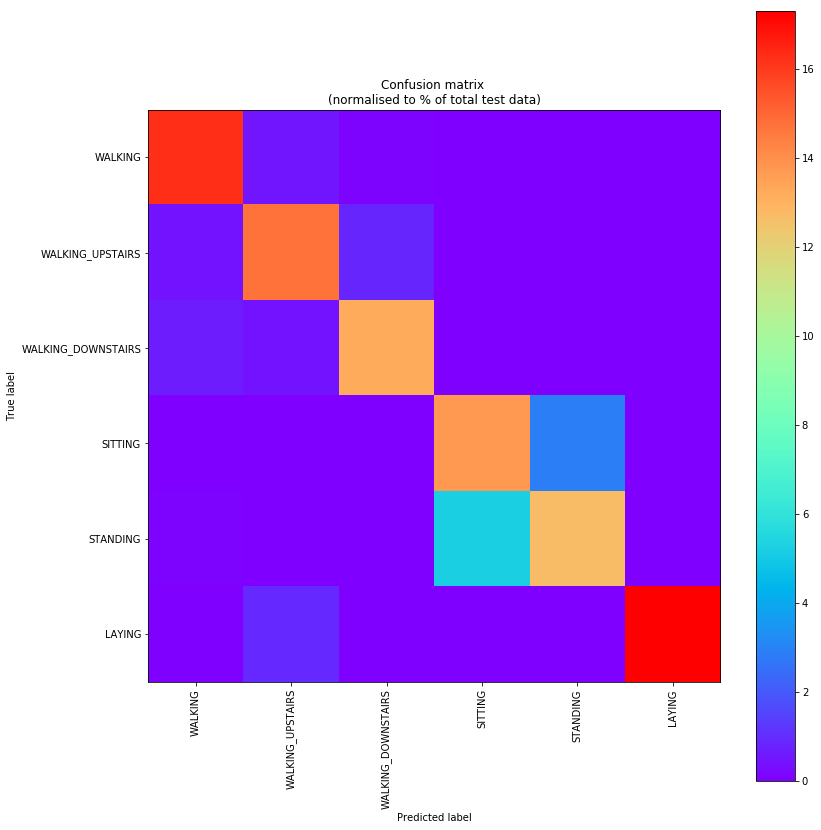

In [5]:
width = 12
height = 12
f = plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
f.savefig("lstm_conf.pdf", bbox_inches='tight')
f.savefig("lstm_conf.png", bbox_inches='tight')